# Exercise Sheet 1 – Deep Learning with PyTorch

 * Deep Learning for Computer Vision – Summer term 2022
 * Instructor: Constantin Pape
 * Due date: May 9, 2022 before 12AM

# IMPORTANT SUBMISSION INSTRUCTIONS

You should work on the exercises in groups of 3. How exactly you collaborate is up to you, but please make sure that everyone contributes equally and also that you understand all the solutions.
You will be asked to present your group's solution in the tutorials and you should be prepared to present any part of it.

- When you're done, download the notebook and rename it to ```<surname1>_<surname2>_<surname3>.ipynb```
- Only submit the ipynb file, no other file is required, send it to me on Rocket Chat (`pape41`)
- Submit only once
- The deadline is strict
- In addition to submission every member of your group should be prepared to present parts of the exercise in the tutorials.

Implementation
- Do not change the cells which are marked as "Do not change", similarly write your solution to the marked cells.

## How to work on the exercise

You will need access to a machine with a GPU to properly work on the exercises. [Google colab](https://colab.research.google.com/?utm_source=scs-index) offers convenient access to a GPU and has all dependencies that we need preinstalled. You can load this notebook in colab via `File->Open notebook->Upload`. If you have a GPU in your laptop or some other machine with a GPU, you can of course use it instead.

# Introduction

In this task you will get to know the basic tools used by the machine learning community.
Later, we will build a logistic regression model with PyTorch and perform training and prediction on the MNIST dataset.

## Tutorials

Some python libraries are required to accomplish the tasks assigned in this homework. If you feel like you need to follow a tutorial before, feel free to do so:

*   [Pytorch Tutorial](https://pytorch.org/tutorials/)
*   [Seaborn Tutorial](https://seaborn.pydata.org/tutorial.html)


## Imports

Jupyter notebook provides the possibility of using libraries, functions and variables globally. This means, once you import the libraries, functions, etc. you won't have to import them again in the next cell. However, if for any reason you end the session (crash, timeout, etc.), then you'll have to run this cell to have your libraries imported again. So, let's go ahead and import whatever we need in this homework assignment.

In [1]:
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import pathlib
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import sampler

## System checks

Perform some rudimentary system checks. Do we have a CUDA-capable device? Multiple? Is CuDNN active (huge speedups for some networks)?

In [2]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count()

(True, True, 1)

If you see now that now that there is no CUDA-capable device available, you have to activate the GPU.

Go to Edit -> Notebook settings -> Select GPU as Hardware accelerator.

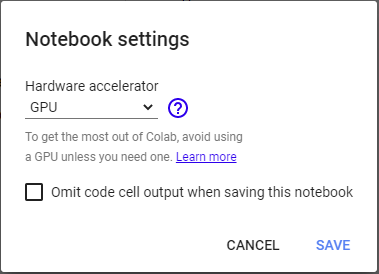

Now check the availability again.

In [3]:
torch.cuda.is_available(), torch.backends.cudnn.is_available(), torch.cuda.device_count(), torch.cuda.current_device()

(True, True, 1, 0)

Choose your device for computation. CPU or one of your CUDA devices?

In [4]:
use_cuda = True
use_cuda = False if not use_cuda else torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')
torch.cuda.get_device_name(device) if use_cuda else 'cpu'
print('Using device', device)

Using device cuda:0


# PyTorch: getting to know tensors

PyTorch is a library for deep learning on arbitray datasets, including irregular input data such as graphs, point clouds and manifolds. 

In this short tutorial we will explore some of its features to handle data in tensors. 
If you want to, you can look into more [detailed PyTorch tutorials](https://pytorch.org/tutorials/) online.

In [5]:
# create numpy array
numpyarray = np.arange(10).reshape(2, 5)
# convert to pytorch tensor
a = torch.from_numpy(numpyarray)

Let us find out what the properties of this tensor 'a' are.

In [6]:
# TODO print the tensor
print(a)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]], dtype=torch.int32)


In [7]:
# TODO print its type
type(a)

torch.Tensor

In [8]:
# TODO print its shape
a.shape

torch.Size([2, 5])

In [9]:
# TODO print its size
print(len(a))

2


In [10]:
# TODO create a new numpy array out of the tensor and print its size
a.detach().numpy()

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

Let's create some new tensors.

In [11]:
# TODO create tensor (2,5) filled with ones of type int and print it
ones_tensor = torch.ones((2,5),dtype=torch.int32)
print(ones_tensor)

tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]], dtype=torch.int32)


In [12]:
# TODO create tensor (3,4) filled with zeros and print it
zeros_tensor = torch.zeros((3,4))
print(zeros_tensor)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])


In [13]:
# TODO transpose the tensor 'a'
a.transpose(0,1)

tensor([[0, 5],
        [1, 6],
        [2, 7],
        [3, 8],
        [4, 9]], dtype=torch.int32)

Now change a value in the numpy array. Does the corresponding tensor change?

In [14]:
# TODO change value in numpy array and inspect the tensor a
numpyarray[0,0] = 10
print(a)

tensor([[10,  1,  2,  3,  4],
        [ 5,  6,  7,  8,  9]], dtype=torch.int32)


In [15]:
a[0,1] = 11
print(numpyarray)

[[10 11  2  3  4]
 [ 5  6  7  8  9]]


**TODO Your answer here**: Yes, it changes

Does it work the other way round as well?

**TODO Your answer here**. yes

Now we want to make use of the different devices available, namely cpu and gpu. 

In [16]:
# TODO move 'a' to the gpu
b = a.to('cuda')

In [17]:
print("a device:",a.device)
print("b device:",b.device)

a device: cpu
b device: cuda:0


In [18]:
a[0,2] = 12
print(b)

tensor([[10, 11,  2,  3,  4],
        [ 5,  6,  7,  8,  9]], device='cuda:0', dtype=torch.int32)


If you change a value in the tensor 'a' now, does the corresponding value in the tensor on the GPU change as well?

**TODO Your answer here**: No

# Deep Learning with Pytorch

The process of training and evaluating a deep learning model begins with **data loading**.
A dataset needs to be chosen on which the model should be trained.
This data might need some preprocessing like resizing or normalizing of images.
Splitting of the data in different sets is necessary. We need a set to train on, a set to validate the training progress and a set to test the model after training.

The next step is to **specify the model and its optimizer**, as well as the loss function.
An important hyperparameter is the learning rate which influences how big the changes of the parameters should be after calculating the loss.

The **model fitting** is split into training and evaluation.
In the training process the model does a forward pass which means the data is presented to the model and the model outputs a prediction.
The loss compares the prediction with the ground truth.
In the backward pass the gradient with regard to the parameter is calculated and the parameter are updated by the gradient step.
In the evaluation process the loss is computed on the entire validation set.
This is done to see how well the model operates on data for which the params were not optimized before in order to avoid overfitting.
The model fitting process is repeated for `N` epochs which is another hyperparameter that needs to be chosen carefully.

After the training we evaluate the final model on the test set.

We'll go through the individual steps in the course of this notebook.


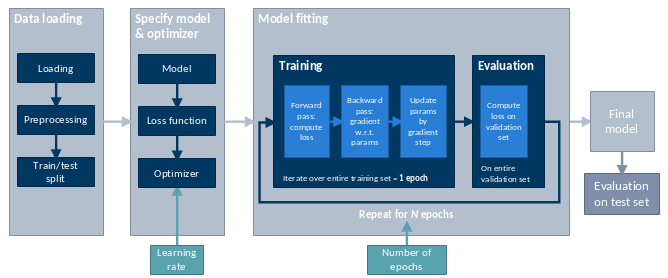

## Data loading

### Loading the MNIST Dataset
This dataset contains handwritten digits, and it is widely used by the machine learning community. It's really useful that you get accustomed with this dataset, as you'll come across it later to learn other concepts. 

The first thing you should do when you begin to work with a data set that you have not used before is to play around with it to get a better understanding of its properties.

**Download** the train split of the MNIST dataset using torchvision dataset classes.

In [19]:
data_dir = pathlib.Path('data/')
#mnist = datasets.MNIST(data_dir, download=True, train=True)
mnist = datasets.MNIST(data_dir, download=False, train=True)

Let's check the first ten samples to see what they look like

In [20]:
X_sample, y_sample = mnist[0]
# TODO: display the label and the image
display(X_sample)
print(y_sample)

5


Look at the types of X and y.

In [21]:
# TODO: display types
type(X_sample), type(y_sample)

(PIL.Image.Image, int)

How many data points are there in the dataset?

In [22]:
len(mnist)

60000

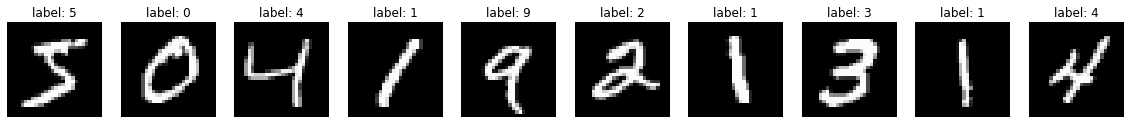

In [23]:
N = 10
fig, axes = plt.subplots(1, N, figsize=(2*N, 2))
X, y = mnist.data, mnist.targets
for ax, image, label in zip(axes.ravel(), X, y):
  ax.set_title("label: {}".format(label))
  ax.axis('off')
  ax.imshow(image.reshape(28,28), cmap='gray') # Remember, images are 28x28

The following plots show more information about the dataset:
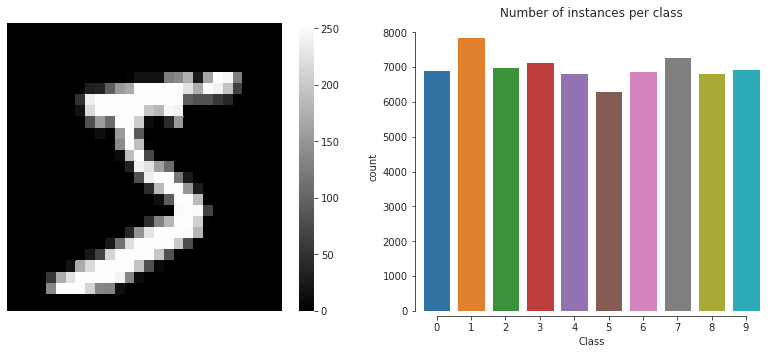


Now that you know what MNIST looks like, you can guess what the task for this dataset is: classifying handwritten digits.

### Preprocessing the data

#### Transformation

We have seen above that the contents of the data set are of type [(PIL.Image.Image, Int)]. However, `pytorch` (the core library, not `torchvision`) is only equipped to work on Tensor objects. So we need to **transform** _PIL.Image.Image_ to _torch.Tensor_. Torchvision takes care of that for us. _transforms.ToTensor_ is a transformation operation that maps a _PIL.Image.Image_ to a torch tensor.

In [24]:
mnist = datasets.MNIST(data_dir, download=True, train=True, transform=transforms.ToTensor())

#### Normalization


Furthermore, we will **normalize** the data to zero-mean and unit-variance. _transforms.Normalize_ takes the mean and std-dev for each channel and rescales the data to zero-mean, unit-variance. 

See https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize for more information.

We can combine multiple transformations via _transforms.Compose_.

So let's create a new dataset that we will be using for testing purposes with those transformations in-place.


In [25]:
tmp_dataloader = torch.utils.data.DataLoader(mnist, batch_size=len(mnist), shuffle=True)

In [26]:
mean = 0.
std = 0.

for images, _ in tmp_dataloader:
    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(tmp_dataloader.dataset)
std /= len(tmp_dataloader.dataset)

In [27]:
#Check if this calculation makes sense
print(mean)
print(std)

tensor([0.1307])
tensor([0.3015])


In [28]:
# # TODO calculate mean and standard deviation of MNIST train dataset
# mean = 
# std = 

In [29]:
mnist_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean,), (std,))])

### Training, Validation and Test Sets

For the correct fitting of a neural network model we need three datasets: one for training, one for validation in the training process, and the last one for testing the results of the training on unseen data. 

Note that you should not use the test set in any part of your training and model selection procedure. It should be only used for showing the final results.

We first need to **load** the datasets.
Above, we did that already to visualize the data and calculate normalization values.
Now we load them and **apply the normalization transform** in this process.

In [30]:
# TODO download the dataset for training and testing, with normalization transform
mnist_train = datasets.MNIST(data_dir, download=True, train=True, transform=mnist_transforms)
mnist_test = datasets.MNIST(data_dir, download=True, train=False, transform=mnist_transforms)

We need to **split** the train dataset in two sets, one for training and one for validation. 
While the training set needs to be quite large, the validation set can be relatively small.
Take 10 % of the dataset as validation set.
Assign samples *randomly* to the training and validation set, using a fixed seed to ensure reproducibility.

In [31]:
# TODO split the train dataset in mnist_train and mnist_val
train_set, val_set = torch.utils.data.random_split(mnist_train, [int(len(mnist_train)*0.9), int(len(mnist_train)*0.1)])

To load the data for model training, we need to define the **dataloaders**.
A dataloader represents a Python iterable over a dataset and draws mini batches with random samples.
Use the batch size as specified above.
Make sure we get shuffled samples in batches.

In [32]:
batch_size = 256

In [33]:
# TODO create dataloader for training, validation and test
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

Let's get a data point now to see what we're dealing with. 

For this, you might want to check out how python's iterator protocol works. It's simple and will give you an important insight into python: https://wiki.python.org/moin/Iterator.

In [34]:
# TODO display an element of the train_dataloader
train_features, train_labels = next(iter(train_dataloader))

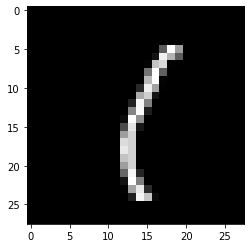

Label: 1


In [35]:
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [36]:
# TODO display the dimensions of x and y
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([256, 1, 28, 28])
Labels batch shape: torch.Size([256])


x has size (\[batchsize\], 1, 28, 28) --> 256 batches (or whatever you have defined in your data loader), 1 channel (the images are monochrome), and the dimensions of the images are 28 height/rows and 28 width/cols.

y has size (\[batchsize\]) --> 256 images (again depends on your data loader config). There's one label for each of the images in the batch.

## Specify model & optimizer

### Specify a model

The task is now to define a model to train on the data. In this simple example, we only need **one fully-connected layer** as defined in *torch.nn.Linear* that produces a predicted label for a specific training image.

Before, we set some variables: 
- the input and output size of the linear layer
- how long we want to train the model (number of epochs) and 
- the learning rate.


In [37]:
epochs = 1
input_dim = 28 * 28
output_dim = 10
lr = 0.001

In [38]:
class LogisticRegression(torch.nn.Module):
    """
    Logistic regression model
    inherits the torch.nn.Module which is the base class 
    for all neural network modules.
    """
    def __init__(self, input_dim, output_dim):
        """ Initializes internal Module state. """
        super(LogisticRegression, self).__init__()
        # TODO define linear layer for the model

        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
        torch.nn.Linear(input_dim, output_dim)
        )
        

    def forward(self, x):
        """ Defines the computation performed at every call. """
        # What are the dimensions of your input layer?
        # TODO flatten the input to a suitable size for the initial layer
        x = self.flatten(x)
        # TODO run the data through the layer
        outputs = self.linear_relu_stack(x)
        
        return outputs

### Instantiate the model

Let us instantiate the model and take a look at the inside. It is always a good idea to verify that the actual architecture is what you intended it to be. Especially, when you start to create layers dynamically it is great for inspection/verification/debugging.

In [39]:
# TODO instantiate the model
model = LogisticRegression(input_dim=input_dim,output_dim=output_dim)


Move the model to the GPU if available.

In [40]:
# TODO move model to device you specified above
#device = "cuda" if torch.cuda.is_available() else "cpu" #This was defined earlier
print(f"Using {device} device")

model = model.to(device)
print(model)

Using cuda:0 device
LogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)


Put the model in training mode.

In [41]:
next(model.parameters()).is_cuda

True

In [42]:
# TODO put the model in train mode
model.train()

LogisticRegression(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
  )
)

### Define a loss function

Since we're dealing with multi-class classification (i.e. multiple categories), softmax is the canonical choice for the final layer activation. Softmax provides us with a distribution of values in [0, 1] that sum up to 1 over all categories.

We then use the cross entropy to compute the loss.

**Hint** Due to numerical reasons, softmax and cross entropy are combined to operate more stable. Read more about it in https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html.

In [43]:
# TODO define loss function
loss_function = torch.nn.CrossEntropyLoss()

### Define the optimizer

The optimizer is the learning algorithm we use. In this case, we use Stochastic Gradient Descent (SGD).

In [44]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## Model fitting

### Train the model

Everything is set for the model to train!

- In the forward pass, the prediction is made using the previously defined model on the images of the dataloader.
- Then the loss (or error) needs to be computed by comparing the prediction to the actual label.
- In the backward pass, the model learns and updates its weights based on the current gradient.

In [45]:
# TODO fill in the missing lines
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # delete the gradients from last training iteration
        optimizer.zero_grad()
        # Forward pass: get predictions
        images = images.to(device="cuda")
        labels = labels.to(device="cuda")
        y_pred = model.forward(images)

        # Compute loss
        loss = loss_function(y_pred,labels)

        # Backward pass -> calculate gradients, update weights
        loss.backward()
        optimizer.step()
        

### Make a prediction

Now that our model is trained, we can make a new prediction by inputting an unseen image of the test dataset.

Run this cell several times, does the model predict accurately?

Set the number of epochs to 10 and try again!

**TODO your answer here**

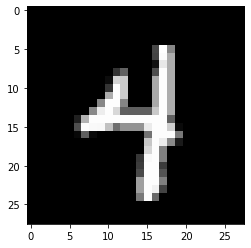

Label: 4


In [46]:
test_features, test_labels = next(iter(test_dataloader))
img = test_features[0].squeeze()
label = test_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [47]:
epochs = 10

for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        # delete the gradients from last training iteration
        optimizer.zero_grad()
        # Forward pass: get predictions
        images = images.to(device="cuda")
        labels = labels.to(device="cuda")
        y_pred = model.forward(images)

        # Compute loss
        loss = loss_function(y_pred,labels)

        # Backward pass -> calculate gradients, update weights
        loss.backward()
        optimizer.step()

In [48]:
# TODO get a random element of the test dataloader
test_features, test_labels = next(iter(test_dataloader))
test_features = test_features[0].to(device="cuda")
test_labels = test_labels[0].to(device="cuda")
# TODO set model in eval mode
model.eval()
# no automatic gradient update needed in evaluation
with torch.no_grad():
    # TODO make a prediction
    y_pred = model(test_features)

# print predicted label and given label
print("predicted label: ", y_pred.argmax())
print("given label: ", test_labels)

predicted label:  tensor(8, device='cuda:0')
given label:  tensor(8, device='cuda:0')


### Track and plot the training and validation error and accuracy

What we have seen so far is the basic principle of training a model and making a prediction. But one might be interested to see more about the training process, for instance how the training error evolves with time and how the accuracy (hopefully) increases while training the model longer.

For this step, we are going to **refine the training process** and **add some important information saving for plotting**.

Create a plot using **seaborn** that contains both the losses on training set and the losses on the validation set for each epoch.

Create a second plot that contains both the accuracies on training set and the accuracies on the validation set for each epoch.

The plots should look similar to this:

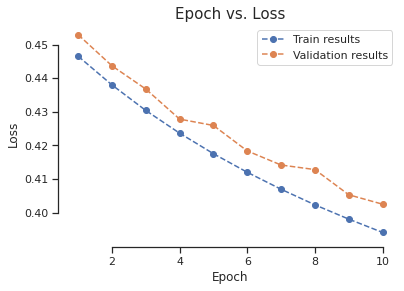 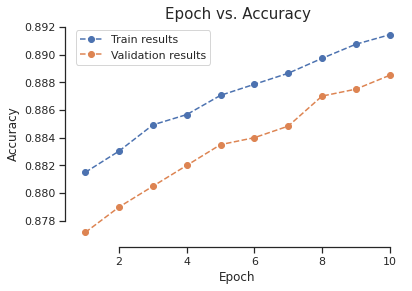

**Note:** Do not forget to add title, axis labels and a legend!
This applies in general, please keep in mind for future exercise sheets.

In [49]:
# TODO write a function that calculates the accuracy
def get_accuracy(correct, total): 
    """
    function to calculate the accuracy given the
        correct: number of correctly classified samples
        total: total number of samples
    returns the ratio
    """
    
    return correct / total

In [50]:
# TODO refine the training function from above
# it should contain:
# - saving of losses
# - calculation of accuracy
# - returning the mean loss and accuracy

def train_function(dataloader, model, loss_fn, optimizer):

    size = len(dataloader.dataset)
    correct = 0
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device="cuda")
        y = y.to(device="cuda")
        pred = model(X)
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
        loss = loss_fn(pred, y)
        losses.append(loss.item())
        # delete the gradients from last training iteration
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    mean_loss = sum(losses)/len(losses)
    accur = get_accuracy(correct,size)
    #loss, current = loss.item(), batch * len(X)
    #print(f"loss: {loss:>7f} accuracy: {accuracy(correct,size)} [{current:>5d}/{size:>5d}]")
    return mean_loss, accur 

In [51]:
# TODO write a validation function that calculates the loss and accuracy on the validation set
# you can also combine it with the training function
def validation_function(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, correct = 0, 0

    with torch.no_grad():
        for X_val, y_val in dataloader:
            X_val = X_val.to(device="cuda")
            y_val = y_val.to(device="cuda")

            pred = model(X_val)
            val_loss += loss_fn(pred, y_val).item()
            correct += (pred.argmax(1) == y_val).type(torch.float).sum().item()

    val_loss /= num_batches
    correct /= size
    print(f"Val Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {val_loss:>8f} \n")
    return val_loss, correct


In [52]:
# TODO write a run_training function that 
# - calls the train and validate functions for each epoch
# - saves the train_losses, val_losses, train_accs, val_accs as arrays for each epoch

def run_training(num_epochs):

    model.train()
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for t in range(num_epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        mean_train_loss, train_accuracy = train_function(train_dataloader, model, loss_function, optimizer)
        print(f"Training result Epoch {t+1} avg loss: {mean_train_loss},avg accuracy: {train_accuracy} ")
        mean_val_loss, val_accuracy = validation_function(val_dataloader, model, loss_function)
        print(f"Training result Epoch {t+1} avg loss: {mean_val_loss},avg accuracy: {val_accuracy} ")

        train_losses.append(mean_train_loss)
        val_losses.append(mean_val_loss)
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)
        
    return train_losses,val_losses,train_accs,val_accs

In [53]:
# TODO call the run_training function and run it for 10 epochs.
num_epochs = 10
train_losses,val_losses,train_accs,val_accs = run_training(num_epochs)

Epoch 1
-------------------------------
Training result Epoch 1 avg loss: 0.44977531430280604,avg accuracy: 0.8809444444444444 
Val Error: 
 Accuracy: 88.2%, Avg loss: 0.443740 

Training result Epoch 1 avg loss: 0.44373950113852817,avg accuracy: 0.8825 
Epoch 2
-------------------------------
Training result Epoch 2 avg loss: 0.44054761345352605,avg accuracy: 0.8827592592592592 
Val Error: 
 Accuracy: 88.4%, Avg loss: 0.433745 

Training result Epoch 2 avg loss: 0.43374478816986084,avg accuracy: 0.8838333333333334 
Epoch 3
-------------------------------
Training result Epoch 3 avg loss: 0.4323596667621938,avg accuracy: 0.8843703703703704 
Val Error: 
 Accuracy: 88.5%, Avg loss: 0.425306 

Training result Epoch 3 avg loss: 0.4253062742451827,avg accuracy: 0.8851666666666667 
Epoch 4
-------------------------------
Training result Epoch 4 avg loss: 0.42512579890789015,avg accuracy: 0.8862592592592593 
Val Error: 
 Accuracy: 88.6%, Avg loss: 0.422148 

Training result Epoch 4 avg loss: 

In [60]:
df_result = pd.DataFrame({"Epoch":list(range(num_epochs)),"Train loss":train_losses,
"Val loss":val_losses,"Train accuracy":train_accs, "Validation accuracy":val_accs })

In [61]:
# TODO write a plot function

def plot_outcome(df, loss=True):
    chosen_columns = []
    if loss:
        chosen_columns = [x for x in df.columns if "loss" in x]
    else: 
        chosen_columns = [x for x in df.columns if "accuracy" in x]

    df_filtered = pd.melt(df, id_vars=['Epoch'], value_vars=chosen_columns)
    plot = sns.lineplot(x="Epoch", y="value",style="variable",data=df_filtered,dashes=True,markers=True )
    plot.set_title("Loss" if loss else "Accuracy")
    return plot


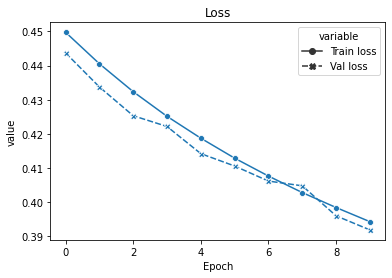

In [62]:
# TODO plot losses
ax = plot_outcome(df_result)

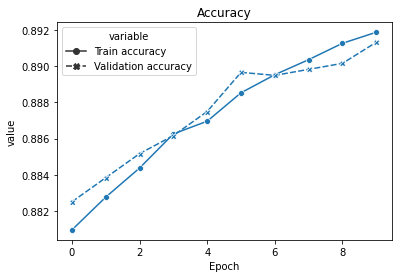

In [63]:
# TODO plot accuracies
ax = plot_outcome(df_result,loss=False)

### Plot the confusion matrix

Additionally to the losses and accuracies we want to plot the confusion matrix at the end of the training procedure, to get an overview about which digits were easily predicted, and which digits were often confused for other, similar looking digits.

1.   Write a function that calculates the confusion values on the validation set.
2.   Normalize the confusion matrix and plot it using seaborn similar to the following format.

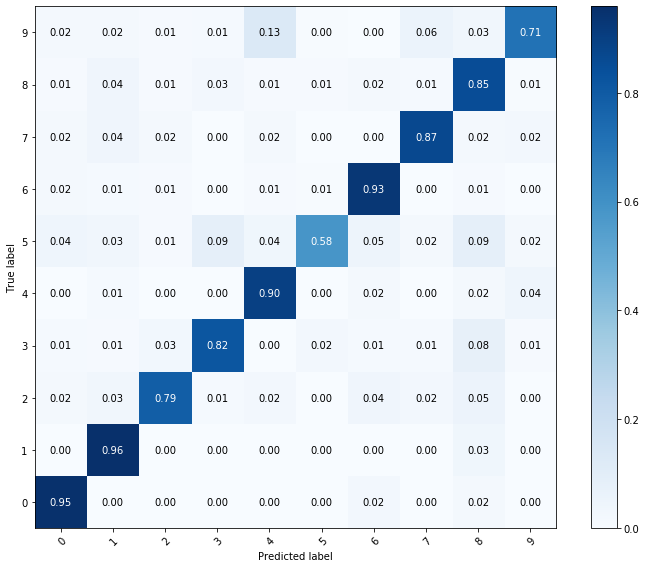

In [64]:
# TODO get a random element of the test dataloader
model.eval()
cm_y_pred = []
cm_y_labels = []
for val_features, val_labels in val_dataloader:
    val_features = val_features.to(device="cuda")
    val_labels = val_labels.to(device="cuda")
    # TODO set model in eval mode
    
    # no automatic gradient update needed in evaluation
    with torch.no_grad():
        # TODO make a prediction
        y_pred = model(val_features)
    y_pred = y_pred.argmax(dim=1)
    cm_y_pred.extend(y_pred.data.tolist())
    cm_y_labels.extend(val_labels.data.tolist())

<AxesSubplot:>

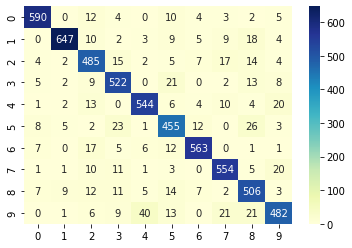

In [70]:
# TODO write a function to calculate the confusion values
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(cm_y_pred, cm_y_labels)
sns.heatmap(cm, annot=True, cmap='YlGnBu', fmt='.0f')

<AxesSubplot:>

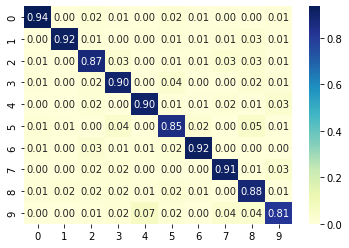

In [71]:
# TODO normalize and plot the confusion matrix1
cm_norm =cm/np.sum(cm,axis=1).reshape(-1,1)
sns.heatmap(cm_norm, annot=True, cmap='YlGnBu', fmt='.2f')

Which digits are often confused with each other?

**TODO your answer here**: the pairs that are often confused are: 
- 9 and 4
- 5 and 8
- 5 and 3
- 9 and 7
- 9 and 8
